In [195]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd

# data
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Feature selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import (
    Lasso,
    LassoCV,
    LinearRegression,
    LogisticRegression,
    Ridge,
    RidgeCV,
)

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)



from sklearn.metrics import f1_score, recall_score, make_scorer

from plot_classifier import plot_classifier, plot_loss_diagram



In [2]:
# copied from 571 lecture 1
import re

import graphviz
from sklearn.tree import export_graphviz


def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
        precision=4,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub(
        "(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)",
        "",
        dot,
    )
    dot = re.sub("(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot)
    return graphviz.Source(dot)


def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for ntree in num_trees:
        model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=ntree))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(num_trees, train_scores, label="train")
    plt.semilogx(num_trees, test_scores, label="cv")
    plt.legend()
    plt.xlabel("number of trees")
    plt.ylabel("scores");

In [3]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

In [4]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [6]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

> - There is class imbalance. But without any context, both classes seem equally important.
> - Let's use accuracy as our metric.

In [7]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [8]:
scoring_metric = "accuracy"

---
---
---
# Lecture 5: Ensembles

So far we have the following models in our toolbox:

- Decision trees (`DecisionTreeClassifier`)
- $k$-nearest neighbours (`KNeighborsClassifier`)
- SVM RBF (`SVC(kernel='rbf')`)
- Naive Bayes (`MultinomialNB`)
- `LogisticRegression`

We will learn

- `RandomForestClassifier`
- `XGBClassifier`
- `LGBMClassifier`
- `CatBoostClassifier`

## 1. Ideas
> Groups can often make better decisions than individuals, especially when group members are diverse enough (***make independent errors***).
1. Decision trees models are 
    - Interpretable 
    - The can capture non-linear relationships
    - They don't require scaling of the data and theoretically can work with categorical features. 
2. But with a single decision trees are likely to overfit. 
3. Idea: Combine multiple trees to build stronger models.
    - These kinds of models are extremely popular in industry. 

## 2. Baseline models

In [9]:
results = {}

`DummyClassifier` baseline

In [10]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

`DecisionTreeClassifier` baseline

>  terribly overfitting

In [11]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,Decision tree
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000)


## 3. `RandomForestClassifier` 

> The validation scores are better although it seems likes we are still overfitting.

#### 1). Ideas

- General idea
    - `fit` a diverse set of decision trees by **injecting randomness** in the classifier construction
    - `predict` by taking the average of predictions given by individual classifiers
    
    
- <b><font color=salmon>Two source of randomness</b></font> in the classifier construction? 
    1. Data: **Build each tree on a bootstrap sample** (i.e., a sample drawn **with replacement** from the training set)
    2. Features: Consider a **random subset of features** <b><font color=salmon>at each split.</b></font>
> Note: There is also something called `ExtraTreesClassifier`, where we add more randomness by consider a random subset of features at each split and **random threshold**.


- Detailed Steps:
    - Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
    - At each node:
        - Randomly select a subset of features out of all features (independently for each node).
        - Find the best split on the selected features. 
        - Grow the trees to maximum depth. 
    - Prediction time    
    - Vote the trees to get predictions for new example. 

#### 2). Code

#### Example 1 
> Default `RandomForestClassifier`

In [12]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,Decision tree,Random forests
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028),10.018 (+/- 0.109)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002),0.129 (+/- 0.010)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003),0.857 (+/- 0.004)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000)


#### Example 2
> Step by step

- create `a random forest with 3 estimators/trees`

In [13]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train);

- Let's get the feature names of transformed features.

In [14]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + list(
        pipe_rf_demo.named_steps["columntransformer"]
        .named_transformers_["pipeline-4"]
        .named_steps["onehotencoder"]
        .get_feature_names()
    )
)

- Let's sample a test example.

In [15]:
test_example = X_test.sample(1)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))
transformed_example = preprocessor.transform(test_example)
# pd.DataFrame(data=transformed_example.toarray().flatten(), index=feature_names)

Classes:  ['<=50K' '>50K']
Prediction by random forest:  ['<=50K']


In [16]:
pipe_rf_demo.predict_proba(test_example)

array([[0.81958266, 0.18041734]])

In [17]:
l = []
for i, tree in enumerate(pipe_rf_demo.named_steps["randomforestclassifier"].estimators_):
    l.append(tree.predict_proba(preprocessor.transform(test_example)))
    
np.array(l).mean(axis=0)

array([[0.81958266, 0.18041734]])

- We can look at different trees created by random forest. 
- Note that each tree looks at different set of features and slightly different data. 



Tree 1


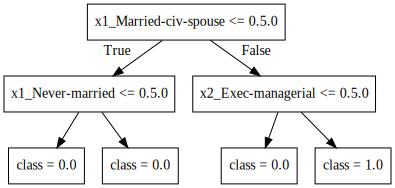

prediction [0.]


Tree 2


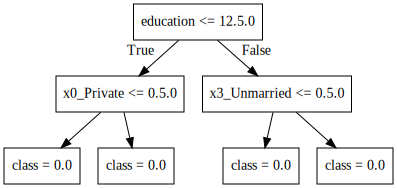

prediction [0.]


Tree 3


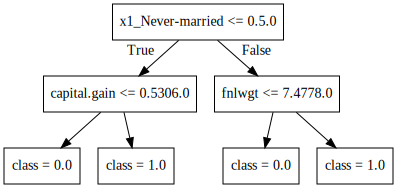

prediction [0.]


In [18]:
for i, tree in enumerate(pipe_rf_demo.named_steps["randomforestclassifier"].estimators_):
    print("\n\nTree", i + 1)
    display(display_tree(feature_names, tree))
    print("prediction", tree.predict(preprocessor.transform(test_example)))

## 4. Some important hyperparameters

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)

#### 1). `n_estimators`

>  Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 


#### a. Number of trees and fundamental trade-off

- seems like we're beating the fundamental "tradeoff" by increasing training score and not decreasing validation score much.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.

<font color=salmon>More trees are always better! We pick less trees for speed.</font>


#### b. Random forests vs decision trees

- Accuracy
    - Random forests are usually <font color=salmon>more accurate</font> compared to decision trees, in fact they are usually one of the best performing off-the-shelf classifiers. 
    - [The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman notes that the error rate depends upon the following:  
        - The correlation between any two trees in the forest. Higher the correlation higher the error rate.
        - The error rate of each individual tree in the forest. Lowering the error rate of the individual trees decreases the forest error rate.

- Speed?
    - Slower than decision trees because we are fitting multiple trees 
    - But can easily parallelize training because all trees are independent of each other 
- Overfitting
    - No depth decision tree tends to overfit 
    - <font color=salmon>Random forests are less likely to overfit</font>
- Interpretability
    - Decision trees are more interpretable 

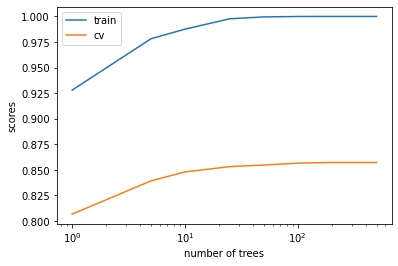

In [19]:
make_num_tree_plot(X_train, y_train, X_test, y_test, (1, 5, 10, 25, 50, 100, 200, 500))

## 5. Other fancier popular tree-based models
Three popular and effective tree-based models 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
    - Not part of `sklearn` but has similar interface. 
    - Install it in your conda environment. 
        ```
        conda install -c conda-forge xgboost
        ```
    - Supports missing values
    - GPU training
    - Networked parallel training
    - Supports sparse data
    - Typically better scores than random forests 
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
    - Not part of `sklearn` but has similar interface. 
    - Install it in your conda environment. 
        ```
        conda install -c conda-forge lightgbm
        ```
    - Small model size
    - Faster
    - Typically better scores than random forests    
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)
    - Not part of `sklearn` but has similar interface. 
    - Install it in your conda environment. 
        ```
        conda install -c conda-forge catboost
        ```
    - Usually better scores but slower compared to `XGBoost` and `LightGBM`  

We'll not go into details. 

#### 1). Comparison

> Note: <b><font color=salmon>We are scaling numeric features but it shouldn't matter for these tree-based models.</b></font>
- overfit
    - Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest followed by random forests.  
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost but it is about 48x slower than LightGBM!
    - XGBoost and LightGBM are faster and more accurate than random forest!    
- Scores times  
    - Prediction times are much smaller in all cases. 
    
    
    
#### What classifier should I use?
- **Simple answer**         
    - Whichever gets the highest CV score making sure that you're not overusing the validation set.
- **Interpretability**          
    - This is an area of growing interest and concern in ML.    
    - How important is interpretability for you? 
    - In the next class we'll talk about interpretability of non-linear models. 
- **Speed/code maintenance**
    - Other considerations could be speed (fit and/or predict), maintainability of the code.
    
Finally, you could use all of them! (Next videos.)

#### 2). Code

In [20]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [21]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)
classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [22]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [23]:
pd.DataFrame(results)

,Dummy,Decision tree,Random forests,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028),10.018 (+/- 0.109),0.918 (+/- 0.053),0.606 (+/- 0.021),9.799 (+/- 0.105),0.748 (+/- 0.089),0.312 (+/- 0.184),8.184 (+/- 0.434)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002),0.129 (+/- 0.010),0.024 (+/- 0.001),0.025 (+/- 0.001),0.130 (+/- 0.012),0.061 (+/- 0.001),0.043 (+/- 0.001),0.036 (+/- 0.006)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003),0.857 (+/- 0.004),0.850 (+/- 0.006),0.813 (+/- 0.003),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004),0.872 (+/- 0.003)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),0.851 (+/- 0.001),1.000 (+/- 0.000),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000),0.900 (+/- 0.001)


## 6. Averaging

> Use all of tree-based models mentioned above, and average result

In [24]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'XGBoost', 'LightGBM', 'CatBoost'])

#### 1). `VotingClassifier`

#### Hyperparameter `voting`
- `voting='hard'` 
    - `predict` output is being averaged
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - `predict_proba` output is being averaged
    - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.
- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.


In [25]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross_val to work!

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models. 
    
Note: it seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

In [26]:
averaging_model.fit(X_train, y_train);

#### 2). How it works

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |

In [27]:
test_g50k = (
    test_df.query("income == '>50K'").sample(4, random_state=2).drop(columns=["income"])
)
test_l50k = (
    test_df.query("income == '<=50K'")
    .sample(4, random_state=2)
    .drop(columns=["income"])
)

- For hard voting, these are the votes:

In [28]:
data = {"Voting classifier": averaging_model.predict(test_g50k)}


r1 = {
    name: classifier.predict(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}


data.update(r1)
pd.DataFrame(data)

,Voting classifier,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost
0,>50K,1,1,1,1,1,1
1,>50K,1,1,1,1,1,1
2,>50K,1,0,1,1,1,1
3,<=50K,0,0,0,0,0,0


- For soft voting, these are the scores:

In [29]:
r1 = {
    name: classifier.predict_proba(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
r1

{'logistic regression': array([[2.28705943e-14, 1.00000000e+00],
        [4.18700308e-01, 5.81299692e-01],
        [4.96627782e-01, 5.03372218e-01],
        [8.87429149e-01, 1.12570851e-01]]),
 'decision tree': array([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[0.  , 1.  ],
        [0.31, 0.69],
        [0.37, 0.63],
        [0.57, 0.43]]),
 'XGBoost': array([[3.9428473e-04, 9.9960572e-01],
        [2.5976986e-01, 7.4023014e-01],
        [3.1037945e-01, 6.8962055e-01],
        [8.1797528e-01, 1.8202470e-01]], dtype=float32),
 'LightGBM': array([[0.00187645, 0.99812355],
        [0.28722892, 0.71277108],
        [0.28457261, 0.71542739],
        [0.8095596 , 0.1904404 ]]),
 'CatBoost': array([[0.00151693, 0.99848307],
        [0.28344311, 0.71655689],
        [0.32029146, 0.67970854],
        [0.81534647, 0.18465353]])}

#### 3). How it performs

It appears that here we didn't do much better than our best classifier! Because:
1. how could the average do better than the best model???
2. From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??

In [30]:
results["Voting"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

In [31]:
pd.DataFrame(results)

,Dummy,Decision tree,Random forests,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost,Voting
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028),10.018 (+/- 0.109),0.918 (+/- 0.053),0.606 (+/- 0.021),9.799 (+/- 0.105),0.748 (+/- 0.089),0.312 (+/- 0.184),8.184 (+/- 0.434),20.671 (+/- 0.202)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002),0.129 (+/- 0.010),0.024 (+/- 0.001),0.025 (+/- 0.001),0.130 (+/- 0.012),0.061 (+/- 0.001),0.043 (+/- 0.001),0.036 (+/- 0.006),0.293 (+/- 0.029)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003),0.857 (+/- 0.004),0.850 (+/- 0.006),0.813 (+/- 0.003),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004),0.872 (+/- 0.003),0.868 (+/- 0.003)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),0.851 (+/- 0.001),1.000 (+/- 0.000),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000),0.900 (+/- 0.001),NaN


## 7. Stacking

#### 1). General ideas
- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use their outputs as _inputs to another model_.
- By default for classification, it uses `LogisticRegression`.
  - We don't need a complex model here necessarily, more of a weighted average.
  - <font color=salmon>The features going into the `LogisticRegression` are the classifier outputs, not the original features!</font>
  - So the number of coefficients = the number of base estimators!
  
  
#### Averaging VS Stacking

<center>
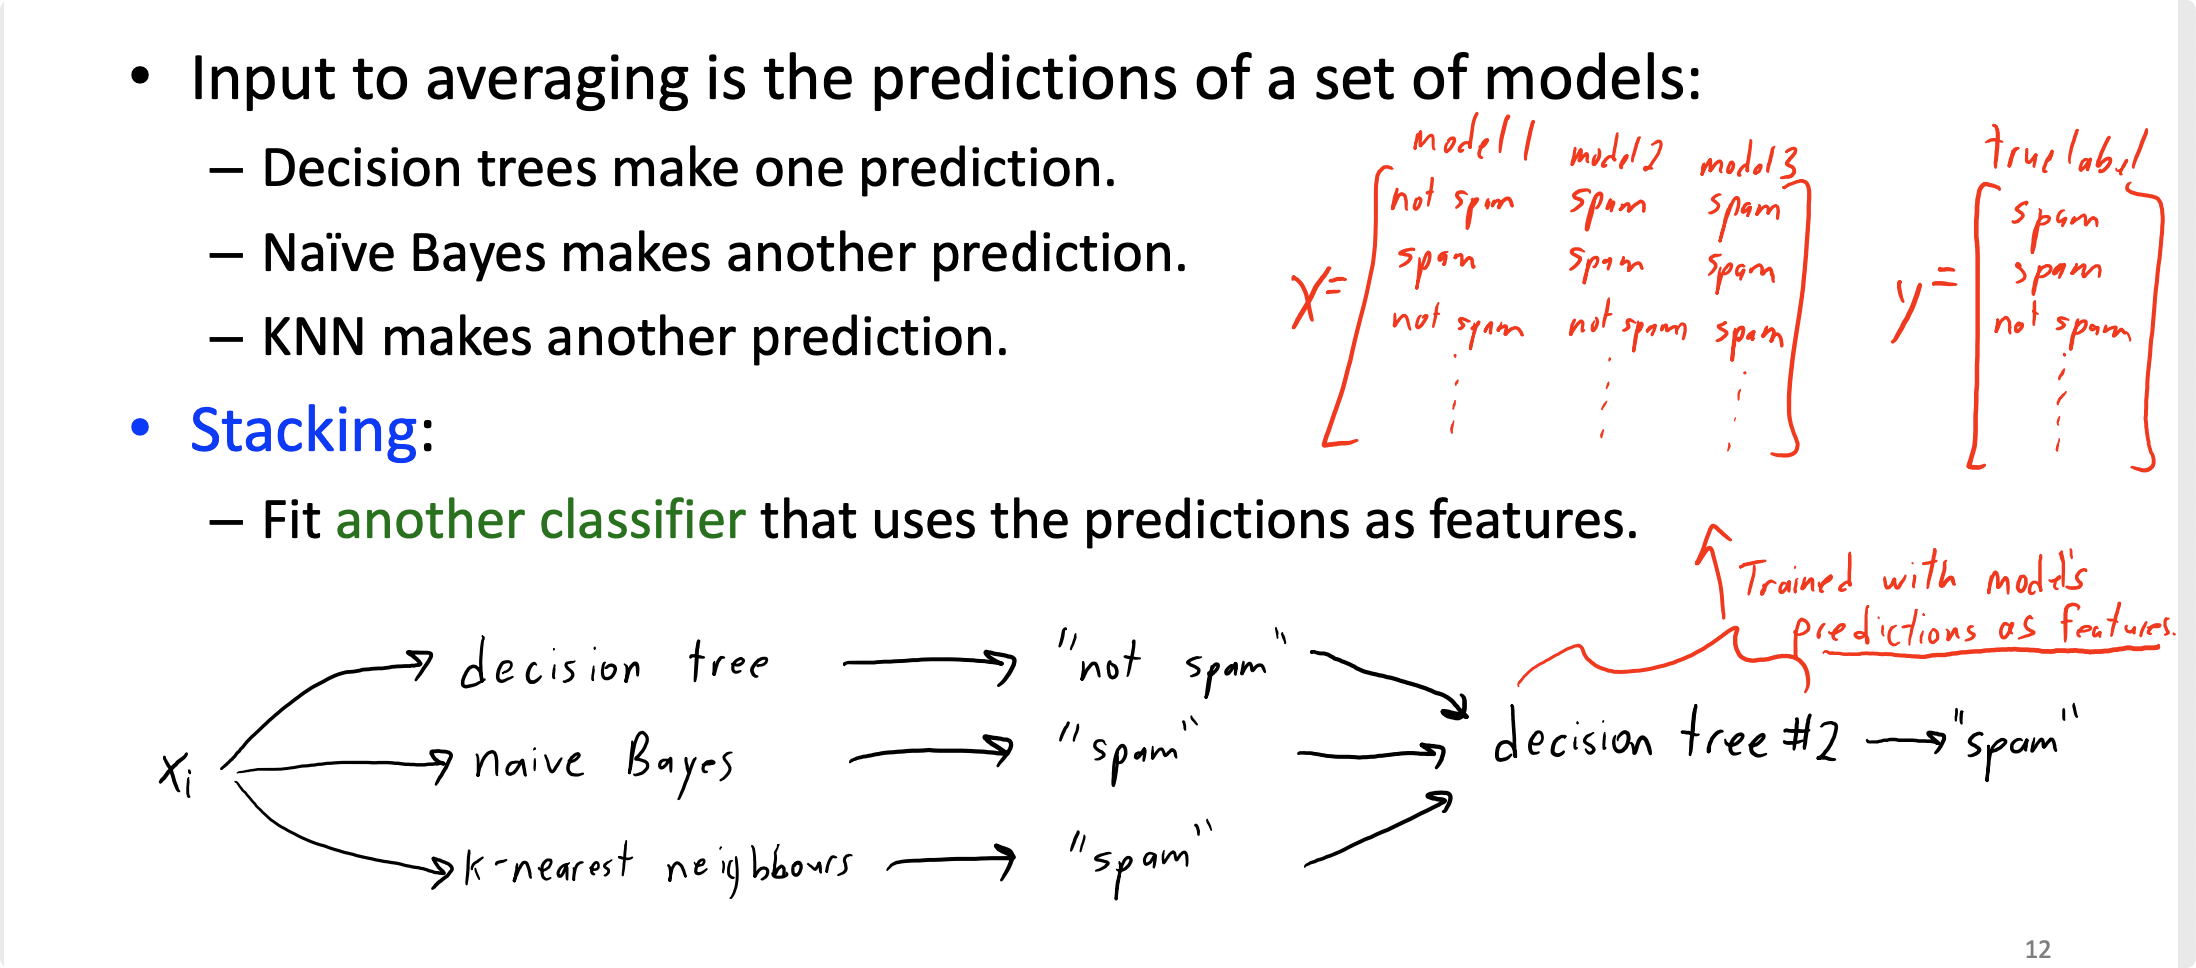
</center>


#### Pros VS Cons
- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a better score.
- What is an disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - Slower, more code maintenance issues.

#### 2). Code

In [32]:
from sklearn.ensemble import StackingClassifier

In [33]:
# The code starts to get too slow here; so we'll remove CatBoost.
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [34]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

**What's going on in `fit`?**

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)
  
 > Note that estimators_ are fitted on the full X (not sure why it needs to do this) while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

In [35]:
stacking_model.fit(X_train, y_train);

**Here is the input features (X) to the meta-model:**

In [36]:
valid_sample = train_df.sample(4, random_state=2).drop(columns=["income"])

In [37]:
r3 = {
    name: pipe.predict_proba(valid_sample)
    for (name, pipe) in stacking_model.named_estimators_.items()
}
r3

{'logistic regression': array([[4.33383448e-01, 5.66616552e-01],
        [9.99018408e-01, 9.81592385e-04],
        [8.60460370e-01, 1.39539630e-01],
        [9.95291692e-01, 4.70830813e-03]]),
 'decision tree': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[0.88, 0.12],
        [1.  , 0.  ],
        [0.95, 0.05],
        [1.  , 0.  ]]),
 'XGBoost': array([[0.7709182 , 0.2290818 ],
        [0.9985829 , 0.00141712],
        [0.92655057, 0.07344944],
        [0.99416995, 0.00583006]], dtype=float32),
 'LightGBM': array([[0.56629894, 0.43370106],
        [0.99263965, 0.00736035],
        [0.91995188, 0.08004812],
        [0.99629847, 0.00370153]])}

- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [38]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_[0],
    index=classifiers_nocat.keys(),
    columns=["Coefficient"],
)

,Coefficient
logistic regression,0.782881
decision tree,-0.011034
random forest,0.216198
XGBoost,2.089171
LightGBM,3.601751


#### 3). Test

- see predictions

In [39]:
stacking_model.predict(test_g50k)

array(['>50K', '>50K', '>50K', '<=50K'], dtype=object)

In [40]:
stacking_model.predict_proba(test_g50k)

array([[0.03382047, 0.96617953],
       [0.19975581, 0.80024419],
       [0.22640723, 0.77359277],
       [0.88813259, 0.11186741]])

- see how well this model performs.

In [41]:
results["Stacking_nocat"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [42]:
pd.DataFrame(results)

,Dummy,Decision tree,Random forests,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost,Voting,Stacking_nocat
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028),10.018 (+/- 0.109),0.918 (+/- 0.053),0.606 (+/- 0.021),9.799 (+/- 0.105),0.748 (+/- 0.089),0.312 (+/- 0.184),8.184 (+/- 0.434),20.671 (+/- 0.202),59.166 (+/- 0.709)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002),0.129 (+/- 0.010),0.024 (+/- 0.001),0.025 (+/- 0.001),0.130 (+/- 0.012),0.061 (+/- 0.001),0.043 (+/- 0.001),0.036 (+/- 0.006),0.293 (+/- 0.029),0.265 (+/- 0.005)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003),0.857 (+/- 0.004),0.850 (+/- 0.006),0.813 (+/- 0.003),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004),0.872 (+/- 0.003),0.868 (+/- 0.003),0.872 (+/- 0.003)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),0.851 (+/- 0.001),1.000 (+/- 0.000),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000),0.900 (+/- 0.001),NaN,0.900 (+/- 0.006)


## 8. T/F questions

1. Every tree in a random forest uses a different bootstrap sample of the training set. 
> True
2. To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features. 
> - False
> - Each tree gets the full set of features, but at each node, only a random subset of features is considered.
3. A reasonable implementation of `predict_proba` for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities. 
> - True
4. `RandomForestClassifier`, increasing the hyperparameter `max_features` (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error. 
> - True
> - Increase the `max_features`, each tree in the random forest will be similar to using decision tree model except bootstrapping sample.
5. A random forest with only one tree is likely to get a higher training error than a decision tree of the same depth. 
> - True
> - Because the tree inside the random forest is using a bootstrap sample, NOT original data. And at each split, it only has access to a subset of features.

# Lecture 6: Feature Importances beyond Linear Models and Loss Functions

- One problem is that often simple models are interpretable but not accurate.
- But more complex models (e.g., LightGBM) are less interpretable.

<center>
<img src="img/shap_motivation.png" width="300">
</center>    

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


#### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

#### Why do we want to use SHAP?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be use on **deployment** predictions!

In [43]:
pd.DataFrame(results)

,Dummy,Decision tree,Random forests,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost,Voting,Stacking_nocat
fit_time,0.011 (+/- 0.001),0.666 (+/- 0.028),10.018 (+/- 0.109),0.918 (+/- 0.053),0.606 (+/- 0.021),9.799 (+/- 0.105),0.748 (+/- 0.089),0.312 (+/- 0.184),8.184 (+/- 0.434),20.671 (+/- 0.202),59.166 (+/- 0.709)
score_time,0.008 (+/- 0.000),0.028 (+/- 0.002),0.129 (+/- 0.010),0.024 (+/- 0.001),0.025 (+/- 0.001),0.130 (+/- 0.012),0.061 (+/- 0.001),0.043 (+/- 0.001),0.036 (+/- 0.006),0.293 (+/- 0.029),0.265 (+/- 0.005)
test_score,0.633 (+/- 0.004),0.813 (+/- 0.003),0.857 (+/- 0.004),0.850 (+/- 0.006),0.813 (+/- 0.003),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004),0.872 (+/- 0.003),0.868 (+/- 0.003),0.872 (+/- 0.003)
train_score,0.635 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),0.851 (+/- 0.001),1.000 (+/- 0.000),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000),0.900 (+/- 0.001),NaN,0.900 (+/- 0.006)


## 1. Feature importances in linear models

#### `LogisticRegression`

> Using `coef_[0]`

In [44]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train);

> - Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
> - Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

In [45]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df[:10]

,coefficient,magnitude
capital.gain,2.356479,2.356479
x1_Married-AF-spouse,1.742552,1.742552
x2_Priv-house-serv,-1.409136,1.409136
x1_Married-civ-spouse,1.341330,1.341330
x3_Wife,1.276553,1.276553
x4_Columbia,-1.102074,1.102074
x2_Prof-specialty,1.071389,1.071389
x2_Exec-managerial,1.048844,1.048844
x4_Dominican-Republic,-1.010218,1.010218
x3_Own-child,-0.997877,0.997877


## 2. Model interpretability beyond linear models

We will be looking at three ways for model interpretability. 

- `sklearn` models
> `feature_importances_` 

- Non-`sklearn` models
> - [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial)
> - [SHAP](https://github.com/slundberg/shap)

#### 1). `sklearn` `feature_importances_`

- Many `sklearn` models have `feature_importances_` attribute.
- For tree-based models it's calculated based on impurity (gini index or information gain).
- For example, let's look at `feature_importances_` of `RandomForestClassifier`. `

In [46]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train);

<b><font color=salmon size=6>ATTENTION</font></b>

- Unlike the linear model coefficients, `feature_importances_` <b><font color=salmon>do not have a sign!</font></b>
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

In [47]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


***Feature importance in `RandomForestClassifier` VS `LogisticRegression`***


Do these importances match with importances identified by logistic regression? 
- Both models agree on `age`, `education`, `capital.gain`
- The actual numbers for random forests and logistic regression are not really comparable. 

In [48]:
data = {
    "random forest importance": pipe_rf.named_steps[
        "randomforestclassifier"
    ].feature_importances_,
    "logistic regression importances": pipe_lr.named_steps["logisticregression"]
    .coef_[0]
    .tolist(),
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)
imps.sort_values(by="random forest importance", ascending=False)[:10]

,random forest importance,logistic regression importances
fnlwgt,0.169580,0.078143
age,0.153339,0.359491
education,0.102953,0.183993
capital.gain,0.097686,2.356479
hours.per.week,0.085583,0.370039
x1_Married-civ-spouse,0.064646,1.341330
x3_Husband,0.048896,-0.017643
capital.loss,0.033387,0.281054
x1_Never-married,0.028629,-0.941344
x2_Exec-managerial,0.020458,1.048844


#### 2). for non `sklearn` models

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

You'll have to install it

```
conda install -c conda-forge eli5
```

In [49]:
import eli5

/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


##### `XGBClassifier`

In [50]:
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_xgb.fit(X_train, y_train)


eli5.explain_weights(pipe_xgb.named_steps["xgbclassifier"], feature_names=feature_names)

Weight,Feature
0.4061,x1_Married-civ-spouse
0.0547,capital.gain
0.0441,x3_Own-child
0.0349,education
0.0325,x2_Other-service
0.0268,capital.loss
0.0247,x2_Prof-specialty
0.0179,x2_Exec-managerial
0.0178,x2_Tech-support
0.0172,x2_Handlers-cleaners


##### `LGBMClassifier`

In [51]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train)


eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3558,x1_Married-civ-spouse
0.1910,capital.gain
0.1363,education
0.0852,age
0.0639,capital.loss
0.0418,hours.per.week
0.0245,fnlwgt
0.0134,x2_Exec-managerial
0.0120,x2_Prof-specialty
0.0067,x2_Other-service


##### `RandomForestClassifier`

In [52]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.1696 ± 0.0113,fnlwgt
0.1533 ± 0.0396,age
0.1030 ± 0.0348,education
0.0977 ± 0.0479,capital.gain
0.0856 ± 0.0250,hours.per.week
0.0646 ± 0.1385,x1_Married-civ-spouse
0.0489 ± 0.1117,x3_Husband
0.0334 ± 0.0157,capital.loss
0.0286 ± 0.0740,x1_Never-married
0.0205 ± 0.0211,x2_Exec-managerial


> for `RandomForestClassifier`, let's how different `eli5` and `feature_importances_` see feature importance.

In [53]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


## 3. SHAP  (SHapley Additive exPlanations)
> - Feature importances values tell us globally about which features are important.
> - SHAP explains a specific prediction.

#### a. (optional) SHAP  (SHapley Additive exPlanations)

- The order of the features we consider matters! 
- Example: Suppose you have 3 players in a cooperative game: Mike, Milad, and Tiffany. Each player is rewarded based on what they bring to the group's overall outcome. 
- Suppose Milad is the first member of the group with a score of 4. Then Tiffany joined to bring the score to 9. Then Mike joined and brings the score to 12. 
- So the marginal contributions of Milad, Tiffany, and Mike are 4, 5, and 3, respectively. 
- What if Mike and Tiffany have very similar skill set? In that case, if Mike had joined earlier than Tiffany, his marginal contribution would have been higher. 
- **SHAP** values 
    - In cooperative games find each player's marginal contribution, averaged over every possible sequence in which the players could have been added to the group.
    - In the above example, we will average over 3! combinations of players.
- Computationally challenging
    - SHAP provides an efficient way to deal with this. 
    
    
#### b. Provides explainer for different kinds of models

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)


#### c. Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

In [54]:
import shap

- Let's create a dataframe with our transformed features.

In [55]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)

#### 1). `explainer` AND `shap_values`

- Let's calculate SHAP values on a sample of the training data. 
- There will be a SHAP value for each example and each feature. 
- This takes a while so I am doing it only on a sample. 

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)


X_train_sample = X_train_enc.sample(1000, random_state=2)

# explainer
explainer = shap.TreeExplainer(rf)

# shap_values
shap_values = explainer.shap_values(X_train_sample)

In [57]:
shap_values

[array([[-1.54893487e-02,  2.34296892e-02,  2.36115464e-02, ...,
         -3.78881987e-05,  4.92368489e-06, -7.87994013e-05],
        [ 3.28517280e-02,  4.41224161e-03,  2.11116339e-02, ...,
         -4.15863982e-06,  5.23826656e-05, -9.52073918e-03],
        [ 8.23360980e-02, -1.84217988e-02,  2.94209002e-02, ...,
         -1.00096649e-04,  4.19367996e-04,  1.41022192e-03],
        ...,
        [-5.66773697e-02, -3.60666721e-02,  2.34063656e-02, ...,
         -7.62127525e-05, -2.18679579e-05, -5.53130259e-04],
        [ 1.50506026e-01,  1.77746552e-02,  2.91386639e-02, ...,
          1.46130063e-05,  4.82252936e-05,  8.97848535e-05],
        [ 9.84908883e-02,  5.94245590e-03,  2.73505735e-02, ...,
          2.52348430e-04,  9.47272269e-05,  8.94282886e-05]]),
 array([[ 1.54893487e-02, -2.34296892e-02, -2.36115464e-02, ...,
          3.78881991e-05, -4.92368489e-06,  7.87994044e-05],
        [-3.28517280e-02, -4.41224160e-03, -2.11116339e-02, ...,
          4.15863979e-06, -5.23826656e

- For classification it's a bit confusing. It gives SHAP arrays both classes.
- Let's stick to shap values for class 0, i.e., income <= 50K. 

In [58]:
shap_values[0].shape

(1000, 86)

- Let's look at the average SHAP values associated with each feature.

In [59]:
values = np.abs(shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

,SHAP
education,0.052830
x1_Married-civ-spouse,0.052336
capital.gain,0.050258
x3_Husband,0.049654
age,0.048300
...,...
x4_Scotland,0.000015
x2_Armed-Forces,0.000011
x4_Honduras,0.000007
x0_Never-worked,0.000002


#### 2). Force plot

In [60]:
# load JS visualization code to notebook
shap.initjs()

##### a train example

In [61]:
X_train_sample.iloc[11, :]

age                   0.182014
fnlwgt                0.545117
capital.gain         -0.147166
capital.loss         -0.217680
hours.per.week        0.768789
                        ...   
x4_Trinadad&Tobago    0.000000
x4_United-States      1.000000
x4_Vietnam            0.000000
x4_Yugoslavia         0.000000
x4_missing            0.000000
Name: 19791, Length: 86, dtype: float64

In [62]:
rf.predict(X_train_sample)[11]

'<=50K'

In [63]:
explainer.expected_value

array([0.75796376, 0.24203624])

Observations: 

- Everything is with respect to class 0 here. 
- The base value for class 0 is 0.758. 
- The score for class 0 is 0.95 and so the prediction is class 0 (<=50K). 
- We see the forces that drive the prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.
- For example, higher value for education (lower education) is pushing us towards <=50K income, whereas the categorical feature x2_Exec-managerial=1 is pushing us towards >50K income. 

In [64]:
rf.predict_proba(X_train_sample)[11]

array([0.95, 0.05])

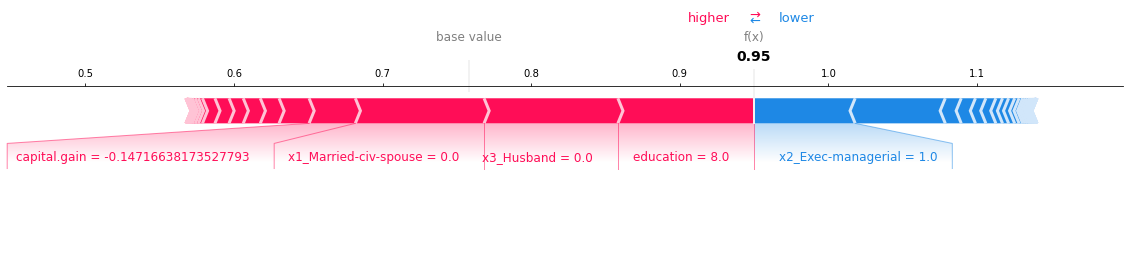

In [65]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][11, :],
    X_train_sample.iloc[11, :],
    matplotlib=True,
)

- Note: a nice thing about SHAP values is that
<font color = salmon>
    
    $$\text{sum of `shap_values` of all features for an example} + \text{`explainer.expected_value[0]`} \;\;=\;\; \text{`predict_proba` score for class 0}$$

    BUT, Not for all models. For random forests you do get `predict_proba` scores but for light GBMs you don't.
</font>

In [66]:
shap_values[0][11].sum() + explainer.expected_value[0]

0.9500000001056053

In [67]:
rf.predict_proba(X_train_sample)[11]

array([0.95, 0.05])

##### a test example

In [68]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_sample = X_test_enc.sample(200, random_state=2)

In [69]:
test_shap_values = explainer.shap_values(X_test_sample)

In [70]:
rf.predict_proba(X_test_sample)[0]

array([0.94, 0.06])

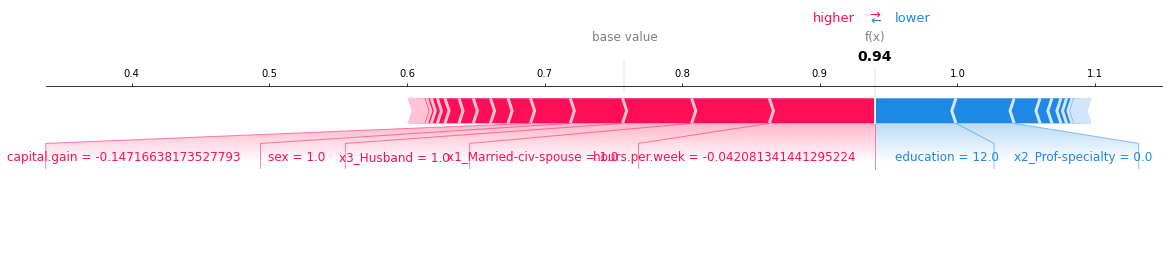

In [71]:
shap.force_plot(
    explainer.expected_value[0],
    test_shap_values[0][0, :],
    X_test_enc.iloc[0, :],
    matplotlib=True,
)

#### 3). Summary plot

The Summary plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- In this case, x1_Married-civ-spouse seems like the most important feature on average.  
- Higher SHAP value means positive association with class 0 (<=50K class) in this case because we are using SHAP values for class 0. 
- Example: Smaller values of age seem to have positive association with class 0. 

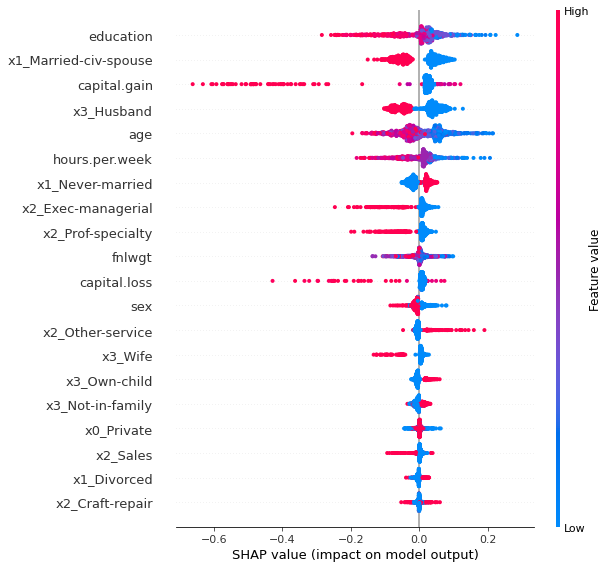

In [72]:
shap.summary_plot(shap_values[0], X_train_sample)

#### 4). Dependence plot

The Dependence plot below shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for 1000 examples above.
- The x-axis represents values of the feature age.
- The y-axis is the SHAP value for the feature of an example, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. 
- Lower values of `age` have higher SHAP values for class `0` ("<=50K"). **This means that lower values of age have positive association with class 0.**
- The color corresponds to a second feature (`x1_Married-civ-spouse` feature in this case) that may have an interaction effect with the feature we are plotting. 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


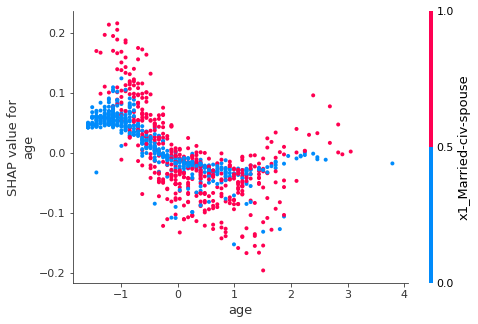

In [73]:
shap.dependence_plot("age", shap_values[0], X_train_sample)

## 4. Loss Function

In [74]:
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression

#### 1). the squared loss



- You have seen least squares for linear regression:

$$\min_w \sum_{i=1}^n \left(w^Tx_i - y_i\right)^2$$

- (Note: we will use $w$ instead of $\beta$ for the regression coefficients / weights.)
- This function that we're minimizing is called the **loss function**.

#### 2). the absolute value loss 
> robust linear regression

- An example of a different loss function would be the absolute value loss:

$$\min_w \sum_{i=1}^n \left| w^Tx_i - y_i \right|$$

- What are the implications of switching between these different choices? 


#### 3). Outliers

In [75]:
def lr_loss_squared(w, X, y):
    return np.sum((X @ w - y) ** 2)

In [76]:
def lr_loss_abs(w, X, y):
    return np.sum(np.abs(X @ w - y))

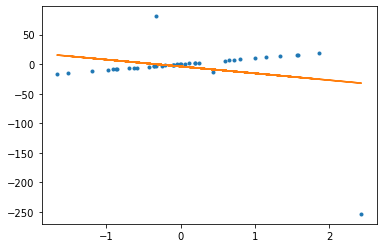

In [77]:
def gen_outlier_data(n=40, Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 10 * x
    # add random outliers
    y[:Noutliers] = -100 * (x[:Noutliers] + np.random.randn(Noutliers))

    X = x[:, None]  # reshape for sklearn

    return X, y


np.random.seed(5)

X, y = gen_outlier_data()
lr = LinearRegression()
lr.fit(X, y)

plt.plot(X, y, ".")
plt.plot(X, lr.predict(X));

In [78]:
X_1 = np.concatenate((X, np.ones(X.shape)), axis=1)

In [79]:
w_min = minimize(lr_loss_squared, np.zeros(2), args=(X_1, y)).x

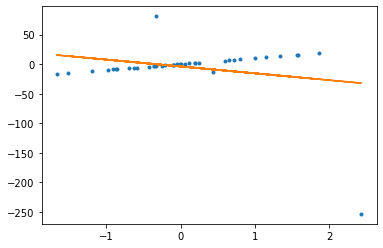

In [80]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min);

In [81]:
w_min_abs = minimize(
    lr_loss_abs, np.zeros(2), args=(X_1, y)
).x  # don't try this at home

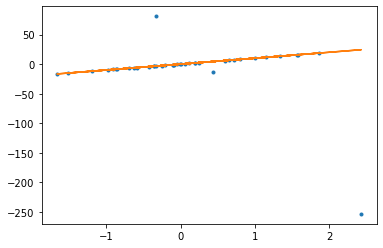

In [82]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min_abs);

- So, it seems like we got very diffrent fits by changing the loss function.
- In this case, the absolute loss gave us robust regression.
- The loss function is important!

#### 4). an interpretation of the mean and median

- The mean is the number that minimizes the squared loss between itself and the set of numbers.
- The median is the number that minimizes the absolute loss between itself and the set of numbers.

So if you believe the median is more robust than the mean, you should believe the absolute value loss is more robust than the squared loss.

In [83]:
nums = np.array([1, 7, 4, -3, 3.4, 100, 50])

print("Mean of the numbers:", np.mean(nums))
print("Median of the numbers:", np.median(nums))

Mean of the numbers: 23.2
Median of the numbers: 4.0


In [84]:
squared_loss = lambda x: np.sum(np.square(x - nums))
print(
    "Value the minimizes the squared distance from the numbers:",
    minimize(squared_loss, 0).x,
)

Value the minimizes the squared distance from the numbers: [23.19999869]


In [85]:
absolute_loss = lambda x: np.sum(np.abs(x - nums))
print(
    "Value the minimizes the absolute value distance from the numbers:",
    minimize(absolute_loss, 0).x,
)

Value the minimizes the absolute value distance from the numbers: [3.99999999]


#### 5). big picture

We can start to think of (a lot of) ML as a 3-step process:

1. Choose your model
2. Choose your loss function
3. Choose your optimization algorithm

What do these do?

1. The model controls the space of possible functions from $X$ to $y$.
  - For example, a linear model can only learn linear functions.
2. The loss function tells us how to compare these various functions.
  - For example, is $y=2x_1+3x_2$ a better model than $y=10x_1-x_2$?
3. The optimization algorithm computationally finds the minimum of the loss function.
  - You will learn about this in DSCI 572. 

#### 6). optimization algorithm

- Loss function example: logistic regression vs. SVM

In [86]:
n = 100
d = 2

X = np.random.rand(n, d)
y = np.random.choice((-1, +1), size=n, replace=True)
X[y == 1, 0] += 0.5

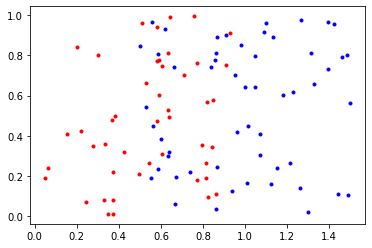

In [87]:
plt.plot(X[y == -1, 0], X[y == -1, 1], ".r")
plt.plot(X[y == 1, 0], X[y == 1, 1], ".b");

In [88]:
y = y[:, None]

In [89]:
def plot_loss_2d(loss_fun, title="", nw1=100, nw2=100):
    wmin = -5
    wmax = 5
    w1_lin = np.linspace(wmin, wmax, nw1)
    w2_lin = np.linspace(wmin, wmax, nw2)
    w1_grid, w2_grid = np.meshgrid(w1_lin, w2_lin)

    w1_flat = w1_grid.flatten()
    w2_flat = w2_grid.flatten()

    W = np.concatenate((w1_flat[None], w2_flat[None]), axis=0)

    loss_flat = loss_fun(W, X, y)
    loss_grid = np.reshape(loss_flat, (nw1, nw2))

    #     plt.imshow(loss_grid, extent=(np.min(w1_lin), np.max(w1_lin), np.min(w2_lin), np.max(w2_lin)), origin='lower')
    CS = plt.contour(w1_grid, w2_grid, loss_grid, levels=20)

    imin = np.argmin(loss_grid)
    plt.plot(w1_flat[imin], w2_flat[imin], "r*", markersize=15)

    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    plt.title(title)


#     plt.colorbar();

- Logistic regression are both linear classifiers, but they use different loss functions.
- You saw in DSCI 571 that these differences have some implications, like the idea of "support vectors".
- We can visulalize these loss functions below:

In [90]:
def loss_lr(w, X, y, λ=1e-3):
    return np.sum(np.log(1 + np.exp(-y * (X @ w))), axis=0) + λ * np.sum(w ** 2, axis=0)


def loss_svm(w, X, y, λ=1e-3):
    return np.sum(np.maximum(0, 1 - y * (X @ w)), axis=0) + λ * np.sum(w ** 2, axis=0)

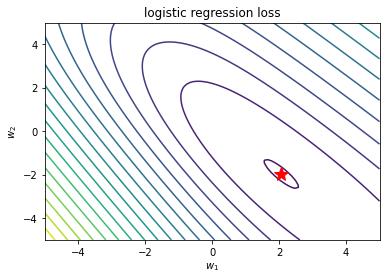

In [91]:
plot_loss_2d(loss_lr, "logistic regression loss")

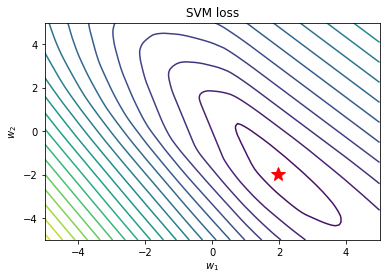

In [92]:
plot_loss_2d(loss_svm, "SVM loss")

- In practice, we need to use different methods to minimize these functions, because the SVM loss is non-smooth.
- However, that is beyond the scope of the course.
- We can see more of the non-smoothness below if we take a vertical slice of these 2d contour plots.

In [93]:
def plot_loss_1d(loss_fun, title="", w1=0):
    w2_grid = np.linspace(-5, 5, 5000)
    w = np.zeros((2, len(w2_grid)))
    w[1] = w2_grid  # vary w2
    w[0] = w1
    loss_slice = loss_fun(w, X, y)
    plt.plot(w2_grid, loss_slice)
    plt.xlabel("$w_2$")
    plt.ylabel("loss")
    plt.title(title);

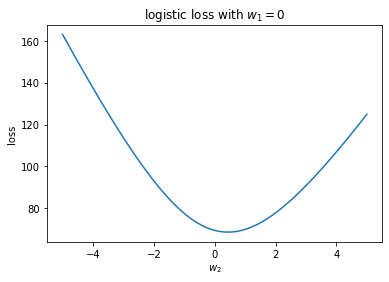

In [94]:
plot_loss_1d(loss_lr, "logistic loss with $w_1=0$")

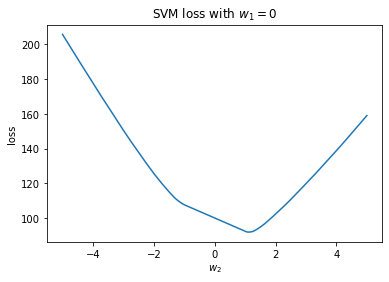

In [95]:
plot_loss_1d(loss_svm, "SVM loss with $w_1=0$");

## 5. T/F questions

1. You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by `feature_importances_` attribute of your model means that increasing the value of feat1 will drive us towards positive class. 
> - False
> - `feature_importances_` values DO NOT have a sign. They tell us about importance, but not an "up or down".
2. eli5 can be used to get feature importances for non `sklearn` models. 
> True
3. With SHAP you can only explain predictions on the training examples. 
> False
4. When you add up the shapely values for an example and the expected value, you get the same score as `predict_proba` output. 
> - False. 
> - Not for all models. For random forests you do get `predict_proba` scores but for light GBMs you don't.

# Lecture 7: Regularization

#### Ideas - smaller slop $w_i$:

> <b><font color=salmon>Idea of regularization: Pick the line/hyperplane with smaller slope</font></b>


- Overfitting    
We’ve said that ***complex models tend to overfit more***. Recall: polynomial degree and train vs. validation scores.

- Controlling model complexity
    - ***Model averaging:*** average over multiple models to decrease variance (e.g., random forests).
    - ***Regularization:*** add a penalty on the complexity of the model


#### Why smaller slope $w_i$:

> larger slope $w_i$ -> complex model -> overfit

<center>
<img src='img/green_or_red.png' width="300"/>
</center>  

- Small change in $x_i$ has a smaller change in prediction $y_i$
- Green line's predictions are less sensitive to the training data. 
- Since green $w$ is less sensitive to training data, validation error might be lower. 

> In this lecture we are going to explore methods to make $w$ less sensitive to the data.  



#### Terminology and notation: L0, L1, and L2 norms 

- L0 "norm" $\lVert w \rVert \rightarrow$ the number of non-zero elements in $w$  
- L1 norm $\lVert w \rVert_1 = \lvert w_1 \rvert + \lvert w_2 \rvert + \dots + \lvert w_n \rvert$ 
- L2 norm $\lVert w \rVert_2 = (w_1^2 + w_2^2 + \dots + w_n^2)^{1/2}$ 

> Data

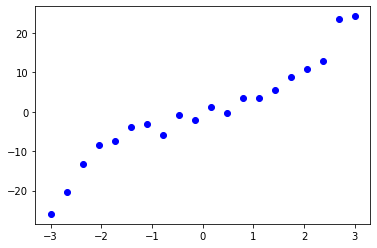

In [96]:
pd.set_option("display.max_colwidth", 200)
n = 20
X_train = np.linspace(-3, 3, n)
y_train = X_train ** 3 + npr.randn(n) * 3

n = 20
X_valid = np.linspace(-3, 3, n)
y_valid = X_valid ** 3 + npr.randn(n) * 3

# transforming the data to include another axis
X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

X_valid = X_valid[:, np.newaxis]
y_valid = y_valid[:, np.newaxis]

plt.scatter(X_train, y_train, color="blue")

## 1. L0 penalty

- Least squares loss after applying L0 penalty: 

$$f(w) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2 + \lambda \lVert w\rVert_0$$

- Notation
    > - $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$
    > - $\lambda \rightarrow$ penalty parameter
    > - $\lVert w\rVert_0 \rightarrow$  L0 norm of $w$ (The number of non-zero values in $w$.)

## 2. L2 regularization

- Standard regularization strategy is L2 regularization
    > We incorporate L2 penalty in the loss function $f(w)$: 
    
$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d w_j^2 \text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Notation
    > - $\lVert Xw - y\rVert_2^2 \rightarrow$ square of the $L2$ norm of $Xw -y$
    > - $\lambda \rightarrow$ regularization strength    
    > - $\lVert w\rVert_2^2 \rightarrow$  square of the L2 norm of $w$      
        - sum of the squared weight values. 
    
- fundamental trade-off:
    - Objective
        - balances getting low error vs. having small slopes $w_j$
    - You can increase the training error. 
    - Nearly-always reduces overfitting and the validation error.       


- How to pick $\lambda$? 
    - Theory: as $n$ grows $\lambda$ should be in the range $O(1)$ to $\sqrt{n}$.
    - Practice: optimize validation set or cross-validation error.
        - Almost always decreases the test error.
        


### 1). `Ridge`

> Refresher:
> - `LinearRegression` gets huge coefficients because of "collinear features".
> - `Ridge`, a regression model "solves" this issue:

$$f(w) = \lVert Xw - y\rVert_2^2 + \alpha \lVert w\rVert_2^2$$


1. [doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

```
class sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
```


2.  The loss function 
    - the linear least squares function
    
3. Regularization 
    - l2-norm.
    
4. Penalty strength
    - `alpha`
    - Larger `alpha` values specify stronger regularization. 

### 2). `LogisticRegression`

> Refresher:
> - a linear classification model


1. [doc]()

```
class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
```

2. Loss function
    - Logistic loss
    - $f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$
<center>
<img src='img/lg_loss.png' width="300"/>
</center>


3. Regularization
    - `penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’`
    
4. Penalty strength
    - `C` 
    > (`alpha = 1 / (2C)`)
    - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

#### a. Complex model

> larger degree -> large coef -> complex

In [97]:
alpha = 0
degrees = [1, 2, 4, 6, 15, 20]
data = {}
for deg in degrees:
    pipe_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=alpha)
    )
    pipe_poly_ridge.fit(X_train, y_train)

    data.setdefault("degree", []).append(str(deg))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_ridge.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_ridge.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_ridge.named_steps["ridge"].coef_[0])]
    )

Ill-conditioned matrix (rcond=3.65968e-18): result may not be accurate.


In [98]:
pd.DataFrame(data)

,degree,train_score,valid_score,weights
0,1,0.912,0.783,[6.43]
1,2,0.913,0.783,"[6.43, 0.073]"
2,4,0.985,0.927,"[2.304, 0.75, 0.694, -0.08]"
3,6,0.985,0.927,"[2.798, 0.622, 0.457, -0.04, 0.022, -0.003]"
4,15,0.996,0.906,"[0.163, -6.455, 20.235, 12.28, -30.891, -8.48, 19.881, 2.897, -6.364, -0.521, 1.068, 0.047, -0.09, -0.002, 0.003]"
5,20,1.0,0.906,"[13.648, -142.898, -133.493, 1055.738, 464.067, -2850.497, -677.684, 3671.919, 506.839, -2564.89, -212.939, 1035.604, 52.034, -246.961, -7.301, 34.11, 0.543, -2.509, -0.016, 0.076]"


#### b. Increase `alpha`

> larger `alpha` -> smaller coef -> less complex

- We also observe the fundamental tradeoff. 
- Increase `alpha`
    - the squared loss term $\lVert Xw - y\rVert_2^2$ generally increases (can remain same).
    - the squared coef term $\alpha \lVert w\rVert_2^2$ decreases.
    
- We see that the rounded values of some weights are close to zero. <b><font color=salmon>BUT NOT ZERO because of the property of L2 regularization</font></b>


    
- L2-Regularization "Shrinking" Example
    - We get least squares with $\lambda = 0$.
    - But we can achieve similar training error with smaller $\lVert w\rVert^2$.
    - $\lVert Xw - y\rVert^2$ increases with $\lambda$, and $\lVert w\rVert^2$ decreases with λ.
        - ***Though individual $w_j$ can increase or decrease with lambda because we use the L2-norm, the large ones decrease the most.***
        
<center>
<img src='img/l2_shrinking_example.png' width="500"/>
</center>    


In [99]:
deg = 10
alphas = 10.0 ** np.arange(-4, 4)
data = {}
for alpha in alphas:
    pipe_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=alpha)
    )
    pipe_poly_ridge.fit(X_train, y_train)

    data.setdefault("alpha", []).append(str(alpha))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_ridge.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_ridge.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_ridge.named_steps["ridge"].coef_[0])]
    )

In [100]:
pd.DataFrame(data)

,alpha,train_score,valid_score,weights
0,0.0001,0.992,0.911,"[2.81, -2.045, 1.722, 2.817, -0.869, -1.015, 0.175, 0.141, -0.01, -0.007]"
1,0.001,0.992,0.911,"[2.81, -2.028, 1.722, 2.803, -0.868, -1.01, 0.175, 0.14, -0.01, -0.007]"
2,0.01,0.992,0.911,"[2.804, -1.869, 1.722, 2.67, -0.867, -0.97, 0.175, 0.135, -0.01, -0.006]"
3,0.1,0.992,0.912,"[2.749, -0.944, 1.717, 1.886, -0.852, -0.731, 0.171, 0.105, -0.01, -0.005]"
4,1.0,0.991,0.919,"[2.372, 0.197, 1.557, 0.801, -0.68, -0.38, 0.138, 0.059, -0.008, -0.003]"
5,10.0,0.982,0.939,"[1.075, 0.194, 0.83, 0.272, -0.007, -0.126, 0.011, 0.02, -0.001, -0.001]"
6,100.0,0.968,0.945,"[0.232, 0.034, 0.298, 0.049, 0.309, 0.0, -0.035, -0.0, 0.001, -0.0]"
7,1000.0,0.947,0.931,"[0.041, 0.005, 0.073, 0.01, 0.115, 0.009, 0.034, -0.0, -0.004, -0.0]"


#### c. `alpha` VS model

> Strong regularization means we our complex model becomes ***smoother***.

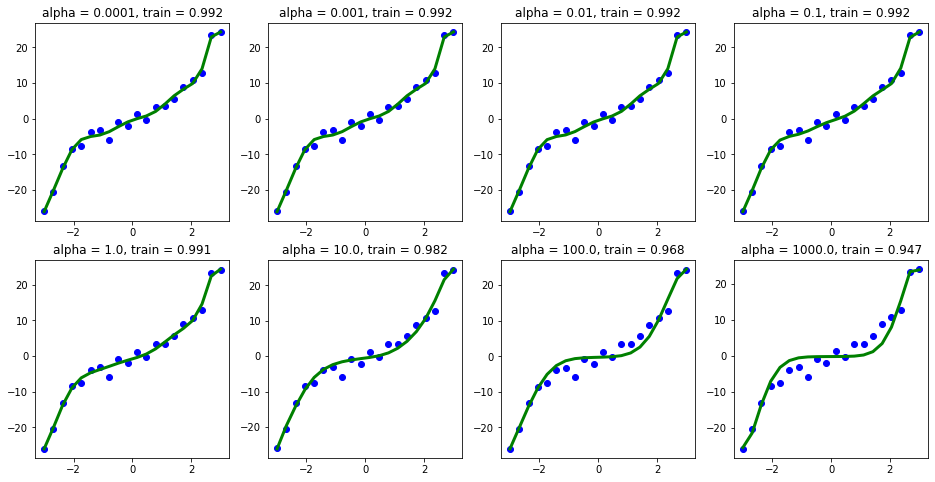

In [101]:
def plot_alpha_train_score():
    plt.figure(figsize=(16, 8))
    count = 1
    alphas = 10.0 ** np.arange(-4, 4)
    degree = 10
    for alpha in alphas:  # needs scikit-learn-0.20
        pipe_poly_lr = make_pipeline(PolynomialFeatures(degree=deg), Ridge(alpha=alpha))
        plt.subplot(2, 4, count)
        pipe_poly_lr.fit(X_train, y_train)
        preds = pipe_poly_lr.predict(X_train)
        plt.scatter(X_train, y_train, color="blue")
        plt.plot(X_train, preds, color="green", linewidth=3)
        plt.title(
            "alpha = %s, train = %0.3f"
            % (str(alpha), pipe_poly_lr.score(X_train, y_train))
        )
        count += 1
        
        
plot_alpha_train_score()

#### d. slop NEVER zero

> The weights become smaller but never become zero

- That said, they won't have much impact on prediction. 
- Strong regularization means the results are not too sensitive to the training data. 
- We are keeping the complexity of the model but making it less sensitive to the feature values! 

In [102]:
deg = 10
pipe_poly_ridge = make_pipeline(
    PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=1000)
)
pipe_poly_ridge.fit(X_train, y_train)
threshold = 1e-6
coeffs = pipe_poly_ridge.named_steps["ridge"].coef_
normalized_weights = np.abs(coeffs[0]) / np.max(np.abs(coeffs[0]))
print("Features with non-zero values: ", np.where(normalized_weights > threshold)[0])

Features with non-zero values:  [0 1 2 3 4 5 6 7 8 9]


#### e. L2 Regularization path

- Weights shrink and converge to zero as $\lambda$ grows but they do not become exactly 0. 

- Imagine that $w_j = 0.000001$. The penalty for this $w_j$ is $0.000000000001$, i.e., a very tiny number. So there is less incentive to decrease the loss. The incentive (slope) is smaller and smaller as we approach 0 and therefore the coefficients do not become exactly 0.  

<center>
<img src='img/l1_l2_path.png' width="500"/>
</center>  

#### f. Should we regularize the y-intercept?

- No! 
    - Why encourage it to be closer to zero? (It could be anywhere.)
    - You should be allowed to shift function up/down globally.
- Yes! 
    - Useful for optimization; It makes the solution unique and it easier to compute $w$    
- Compromise: regularize by a smaller amount than other variables.
    $$f(w) = \lVert Xw + w_0 - y\rVert^2 + \frac{\lambda_1}{2}\lVert w\rVert^2 + \frac{\lambda_2}{2}w_0^2$$

#### g. L2 Properties

1. Solution $w$ is unique. (We are not going into mathematical details.)
2. Almost always improves the validation error. 
3. No collinearity issues.
4. Less sensitive to changes in $X$.
5. Gradient descent converges faster (bigger $\lambda$ means fewer iterations). (You'll learn about Grafient descent in 572.)
6. Worst case: just set $\lambda$ small and get the same performance

## 3. L1 Regularization


### - Similarities with L2-regularization

- L1-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

- L2-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Both shrink weights.
- Both result in lower validation error. 


### - Similarities between L1- and L0-regularization 

- Like L0-norm, it encourages elements of $w$ to be <b><font color=salmon size=4>exactly zero.</font></b> 
- L1-regularization <b><font color=salmon size=4>simultaneously regularizes and selects features.</font></b> 
- Very fast alternative to search and score (L0 penalty).
    - With L0 penalty, we had to 
- L1-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

- L0-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_0$$


#### 1). `Lasso` or L1 `LogisticRegression`

Terminology and notation: Ridge and Lasso

- Linear regression model that uses L2 regularization is called **Ridge** or Tikhonov regularization.
    - [`scikit-learn` Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)
- Linear regression model that uses L1 regularization is called **Lasso**. 
    - [`scikit-learn` Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso)
    > class sklearn.linear_model.Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

#### 2). increase `alpha` in `Lasso`

- Smaller `alpha` values have higher weights 
- Larger `alpha` values results in smaller weights. 
- <b><font color=salmon size=4>Many weights become zero. (Sparsity) </font></b> 
    - We say a linear function is sparse if most of the coefficients are zero. 
    - Example: Here only 2 out of 8 coefficients are non-zero and so it is a sparse function. 
    $$0x_1 + 0.45 x_2 + 0  x_3 + 0x_4 + 1.2x_5 + 0x_6 + 0x_7 + 0x_8$$

In [103]:
deg = 10
alphas = 10.0 ** np.arange(-4, 4)
data = {}
for alpha in alphas:
    pipe_poly_lasso = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False),
        Lasso(alpha=alpha, max_iter=1000),
    )
    pipe_poly_lasso.fit(X_train, y_train)

    data.setdefault("alpha", []).append(str(alpha))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_lasso.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_lasso.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_lasso.named_steps["lasso"].coef_)]
    )
    
pd.DataFrame(data)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.802412096918555, tolerance: 0.3005923388954431
Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.905241273587688, tolerance: 0.3005923388954431
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.885094692251414, tolerance: 0.3005923388954431
Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.757557557692248, tolerance: 0.3005923388954431
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9286303079741884, tolerance: 0.3005923388954431
Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.7976157599508, tolerance: 0.3005923388954431


,alpha,train_score,valid_score,weights
0,0.0001,0.989,0.92,"[3.843, 0.766, -0.479, -0.143, 0.177, 0.012, 0.004, 0.001, -0.001, -0.0]"
1,0.001,0.989,0.92,"[3.833, 0.757, -0.473, -0.14, 0.176, 0.011, 0.004, 0.001, -0.001, -0.0]"
2,0.01,0.989,0.921,"[3.74, 0.67, -0.419, -0.107, 0.168, 0.007, 0.004, 0.001, -0.001, -0.0]"
3,0.1,0.987,0.928,"[2.975, 0.231, -0.0, 0.015, 0.108, -0.0, 0.005, 0.0, -0.001, -0.0]"
4,1.0,0.973,0.946,"[0.0, 0.0, 1.081, 0.0, 0.023, 0.01, 0.0, -0.0, -0.0, -0.0]"
5,10.0,0.948,0.937,"[0.0, 0.0, 0.0, 0.0, 0.193, 0.0, 0.015, 0.002, -0.003, -0.0]"
6,100.0,0.918,0.933,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054, 0.0, -0.005, -0.0]"
7,1000.0,0.711,0.804,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.002, -0.0]"


In [104]:
deg = 10
pipe_poly_lasso = make_pipeline(
    PolynomialFeatures(degree=deg, include_bias=False), Lasso(alpha=100)
)
pipe_poly_lasso.fit(X_train, y_train)
threshold = 1e-6
coeffs = pipe_poly_lasso.named_steps["lasso"].coef_
normalized_weights = np.abs(coeffs) / np.max(np.abs(coeffs))
print("Features with non-zero values: ", np.where(normalized_weights > threshold)[0])

Features with non-zero values:  [6 8 9]


#### 3). L1 properties

1. Almost always improves the validation error. 
2. Can learn with exponential number of irrelevant features.
3. Less sensitive to changes in $X$.
4. The solution is **not unique.** (If interested in more explanation on this, see slide 43 in [this slide deck](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf).)

## 4. Feature selection using L1

- Feature selection methods we have seen so far: 
    - RFE
    - Search and score with L0-regularization (e.g., forward search)
- An effective way of feature selection: L1-regularization 

> data

In [166]:
from sklearn.datasets import load_boston, load_breast_cancer

boston_housing = load_boston()

boston_df = pd.DataFrame(boston_housing.data, columns=boston_housing.feature_names)
boston_df["target"] = boston_housing.target
train_df, test_df = train_test_split(boston_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [167]:
results = {}

#### 1). RFE

In [168]:
pipe_rfe_ridgecv = make_pipeline(
    StandardScaler(), PolynomialFeatures(), RFECV(Ridge(), cv=10), RidgeCV()
)

In [169]:
results["RFE + Ridge"] = mean_std_cross_val_scores(
    pipe_rfe_ridgecv, X_train, y_train, return_train_score=True
)
pd.DataFrame(results)

,RFE + Ridge
fit_time,1.219 (+/- 0.045)
score_time,0.002 (+/- 0.000)
test_score,0.802 (+/- 0.088)
train_score,0.907 (+/- 0.035)


#### 2). L1 `LassoCV`

Note: Although L2 regularization doesn't make coefficients zero, you can still use it for feature selection using `SelectFromModel` with a threshold. See documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html). 

In [170]:
from sklearn.feature_selection import SelectFromModel

pipe_l1_ridgecv = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    SelectFromModel(LassoCV(max_iter=2000)),
    RidgeCV(),
)

In [171]:
results["LASSO L1 + Ridge"] = mean_std_cross_val_scores(
    pipe_l1_ridgecv, X_train, y_train, return_train_score=True
)
pd.DataFrame(results)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7431972566714649, tolerance: 1.7210772403100776


,RFE + Ridge,LASSO L1 + Ridge
fit_time,1.219 (+/- 0.045),0.415 (+/- 0.073)
score_time,0.002 (+/- 0.000),0.002 (+/- 0.000)
test_score,0.802 (+/- 0.088),0.815 (+/- 0.078)
train_score,0.907 (+/- 0.035),0.919 (+/- 0.014)


- Let's look at the coefficients.

In [172]:
pipe_l1_ridgecv.fit(X_train, y_train)
pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_

array([ 0.        , -0.        ,  0.        ,  0.63569027,  0.        ,
       -0.98689837,  3.55026179, -1.31082485, -2.66589432,  0.4751201 ,
       -0.        , -0.59087554,  1.12418015, -3.07261127,  0.10195516,
       -0.        , -0.        ,  5.2006241 , -0.20699814,  0.40540676,
       -0.        , -0.        , -0.47615371,  0.        , -0.        ,
       -0.10305434,  0.433369  ,  0.09021728, -0.31918278, -0.07189749,
       -0.        , -0.0297253 , -0.13775129, -0.2564756 , -0.        ,
        1.41504546, -0.13596046,  0.        , -0.25713116,  0.70304396,
        0.        ,  2.41947452,  0.76452374,  0.18993168,  0.89252337,
       -0.        ,  0.01543774, -0.14731665,  0.        , -1.07087586,
        0.46877825, -1.0369579 , -0.72879662,  0.20370078,  0.        ,
       -0.33684991,  0.        , -0.19279016,  0.0940002 , -0.32156006,
       -0.66742211, -0.17325393, -0.72401858,  1.58968674, -0.80785825,
        0.        , -0.87047052,  0.        ,  0.76079265,  0.08

- when set 0

In [173]:
pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_

1e-05

- How many features were passed to the final model?

In [174]:
print(
    "The number of features after polynomial transformation: ",
    pipe_l1_ridgecv.named_steps["polynomialfeatures"].n_output_features_,
)
print(
    "The number of features passed to the final model: ",
    len(pipe_l1_ridgecv.named_steps["ridgecv"].coef_),
)

The number of features after polynomial transformation:  105
The number of features passed to the final model:  77


- selected feature names

In [175]:
poly_feature_names = pipe_l1_ridgecv.named_steps[
    "polynomialfeatures"
].get_feature_names()  # transformed list to array
support = (
    np.abs(pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_)
    > pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_
)
l1_selected_feats = np.array(poly_feature_names)[support]
l1_selected_feats

array(['x2', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10', 'x11', 'x12', 'x0^2',
       'x0 x3', 'x0 x4', 'x0 x5', 'x0 x8', 'x0 x11', 'x0 x12', 'x1^2',
       'x1 x2', 'x1 x3', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x9', 'x1 x10',
       'x1 x12', 'x2^2', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x9',
       'x2 x10', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x8',
       'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7',
       'x4 x8', 'x4 x10', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x8', 'x5 x9',
       'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x8', 'x6 x9', 'x6 x11',
       'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x11', 'x7 x12', 'x8^2',
       'x8 x9', 'x8 x12', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2',
       'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2'], dtype='<U7')

- learned coef by `RidgeCV`

In [176]:
coef_df = pd.DataFrame(
    data=pipe_l1_ridgecv.named_steps["ridgecv"].coef_,
    index=l1_selected_feats,
    columns=["Coefficient"],
)
coef_df

,Coefficient
x2,1.464352
x4,-1.013904
x5,3.604779
x6,-1.601881
x7,-2.430137
...,...
x10 x11,0.065983
x10 x12,0.269627
x11^2,-0.305546
x11 x12,-0.287693


#### 3). L1 `LogisticRegression`

In [177]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["target"] = breast_cancer.target
train_df, test_df = train_test_split(breast_cancer_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]


In [179]:
pipe_lgr_lgbm = make_pipeline(
    StandardScaler(),
    SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1")),
    LGBMClassifier(),
)

In [180]:
results["LogisticRegression L1 + LGBM"] = mean_std_cross_val_scores(
    pipe_lgr_lgbm,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results)

,RFE + Ridge,LASSO L1 + Ridge,LogisticRegression L1 + LGBM
fit_time,1.219 (+/- 0.045),0.415 (+/- 0.073),0.098 (+/- 0.135)
score_time,0.002 (+/- 0.000),0.002 (+/- 0.000),0.004 (+/- 0.000)
test_score,0.802 (+/- 0.088),0.815 (+/- 0.078),0.961 (+/- 0.037)
train_score,0.907 (+/- 0.035),0.919 (+/- 0.014),1.000 (+/- 0.000)


In [181]:
pipe_lgr_lgbm2 = make_pipeline(
    StandardScaler(),
    SelectFromModel(LassoCV(max_iter=2000)),
    LGBMClassifier(),
)

In [182]:
results["LASSO L1 + LGBM"] = mean_std_cross_val_scores(
    pipe_lgr_lgbm3,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009189749458480279, tolerance: 0.00675205479452055
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008195656692326025, tolerance: 0.006724315068493151


,RFE + Ridge,LASSO L1 + Ridge,LogisticRegression L1 + LGBM,LASSO L1 + LGBM
fit_time,1.219 (+/- 0.045),0.415 (+/- 0.073),0.098 (+/- 0.135),0.389 (+/- 0.135)
score_time,0.002 (+/- 0.000),0.002 (+/- 0.000),0.004 (+/- 0.000),0.004 (+/- 0.000)
test_score,0.802 (+/- 0.088),0.815 (+/- 0.078),0.961 (+/- 0.037),0.960 (+/- 0.032)
train_score,0.907 (+/- 0.035),0.919 (+/- 0.014),1.000 (+/- 0.000),1.000 (+/- 0.000)


## 5. Regularized logistic regression


- Regularization is not limited to least squares. 
- We can add L1 and L2 penalty terms in other loss functions as well. 
- Let's look at logistic regression with L1 and L2 regularization.

> DATA

In [183]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["target"] = breast_cancer.target
train_df, test_df = train_test_split(breast_cancer_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [184]:
custom_scorer = make_scorer(f1_score, pos_label=0)
scoring_metric = custom_scorer

In [185]:
results_classification = {}

#### 1). try `DummyClassifier`

In [186]:
dummy = DummyClassifier()
results_classification["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric, 
)
pd.DataFrame(results_classification)

The default value of strategy will change from stratified to prior in 0.24.


,dummy
fit_time,0.001 (+/- 0.000)
score_time,0.001 (+/- 0.000)
test_score,0.409 (+/- 0.091)
train_score,0.355 (+/- 0.043)


#### 2). `LogisticRegression` with L2

In [187]:
pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression())
results_classification["Logistic Regression L2"] = mean_std_cross_val_scores(
    pipe_lgr_l2, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results_classification)

,dummy,Logistic Regression L2
fit_time,0.001 (+/- 0.000),0.013 (+/- 0.002)
score_time,0.001 (+/- 0.000),0.003 (+/- 0.000)
test_score,0.409 (+/- 0.091),0.970 (+/- 0.011)
train_score,0.355 (+/- 0.043),0.985 (+/- 0.005)


- All coefficients are non-zero.

In [188]:
pipe_lgr_l2.fit(X_train, y_train)
pipe_lgr_l2.named_steps["logisticregression"].coef_

array([[-0.53985391, -0.25214061, -0.49456043, -0.61045146, -0.17406619,
         0.57798312, -0.65877728, -0.98024393,  0.11997381,  0.40647904,
        -1.24795634, -0.10325774, -0.73120148, -0.93158422, -0.23099107,
         0.61431692, -0.03231823, -0.20637638,  0.27288293,  0.73956073,
        -1.04015025, -1.09620691, -0.88548864, -1.02686306, -0.92729009,
        -0.07540269, -0.76656759, -0.73296575, -0.66992505, -0.52093938]])

#### 3). `LogisticRegression` with L1

- The scores are more or less the same with L2.
- But L1 regularization is carrying out feature selection. 
- Many coefficients are 0. 

In [189]:
pipe_lgr_l1 = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", penalty="l1")
)
results_classification["Logistic Regression L1"] = mean_std_cross_val_scores(
    pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1
fit_time,0.001 (+/- 0.000),0.013 (+/- 0.002),0.006 (+/- 0.002)
score_time,0.001 (+/- 0.000),0.003 (+/- 0.000),0.003 (+/- 0.000)
test_score,0.409 (+/- 0.091),0.970 (+/- 0.011),0.967 (+/- 0.007)
train_score,0.355 (+/- 0.043),0.985 (+/- 0.005),0.984 (+/- 0.006)


In [190]:
pipe_lgr_l1.fit(X_train, y_train)
pipe_lgr_l1.named_steps["logisticregression"].coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.35299309,  0.        ,  0.2760846 ,
        -1.99781976,  0.        ,  0.        ,  0.        , -0.12626937,
         0.53858299,  0.        ,  0.        ,  0.        ,  0.22098346,
        -1.48998571, -1.37332619, -0.27967041, -3.63529092, -0.98396956,
         0.        , -1.01979861, -0.65575108, -0.29984558,  0.        ]])

## 6. Regularization and scaling 


- It doesn't matter for decision trees or naive Bayes.
    - They only look at one feature at a time.
- It doesn't matter for least squares:
    - $w_j*(100 mL)$ gives the same model as $w_j*(0.1 L)$ with a different $w_j$
- It matters for $k$-nearest neighbours:
    - Distance will be affected more by large features than small features.
- **It matters for regularized least squares**:
    - Penalizing $w_j^2$ means different things if features $j$ are on different scales
    - Penalizing $w_j$ means different things if features $j$ are on different scales

> DATA

In [191]:
from sklearn.datasets import make_regression
n_samples = 100
n_features = 10

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=10,
    noise=0.50,
    random_state=111,
)
### make the first feature on a huge scale
X[:, 0] = X[:, 0] * 1000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)

#### 1). `LinearRegression`

Normalizing [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
> - normalize: bool, optional, default False
> - This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.


- Let's check whether the linear regression model is different when we normalize vs. when we do not normalize

In [192]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)

lr_scale = LinearRegression(normalize=True)
lr_scale.fit(X_train, y_train)

np.allclose(lr.predict(X_test), lr_scale.predict(X_test))

True

#### 2). `Ridge`

In [193]:
ridge = Ridge(normalize=False)
ridge.fit(X_train, y_train)

ridge_scale = Ridge(normalize=True)
ridge_scale.fit(X_train, y_train)

np.allclose(ridge.predict(X_test), ridge_scale.predict(X_test))

False

#### 3). `Lasso`

In [194]:
lasso = Lasso(normalize=False)
lasso.fit(X_train, y_train)

lasso_scale = Lasso(normalize=True)
lasso_scale.fit(X_train, y_train)

np.allclose(lasso.predict(X_test), lasso_scale.predict(X_test))

False

#### 4). Summary

- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

#### 7. Elastic nets

- Combine good properties from both worlds

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda(\alpha\lVert w\rVert_1 + (1-\alpha)\lVert w\rVert_2^2 )  $$

- $\lambda$ control the strength of regularization 
- $\alpha$ controls the amount of sparsity and smoothness
- L1 promotes sparsity and the L2 promotes smoothness.
- The functional is strictly convex: the solution is unique.
- No collinearity problem 
    - A whole group of correlated variables is selected rather than just one variable in the group.

## 8. Summary

#### - L* regularization

<center>
<img src='img/regularization_summary.png' width="1000" height="1000" />
</center>

>  "Elastic net" (L1- and L2-regularization) is sparse, fast, and unique.

- L0-regularization (AIC, BIC, Mallow’s Cp, Adjusted R2, ANOVA):
   - Adds penalty on the number of non-zeros to select features.

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_0$$    


- L2-regularization (ridge regression):
    - Adding penalty on the L2-norm of $w$ to decrease overfitting:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$    

- L1-regularization (lasso regression):
    - Adding penalty on the L1-norm decreases overfitting and selects features:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

#### - How to use regularization with `scikit-learn`: some examples

- Regression
    - Least squares with L2-regularization: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
    - Least squares with L1-regularization: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
    - Least squares with L1- and L2-regularization: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
    - [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR) ($\epsilon$-insensitive loss function)
        - `epsilon = 0` gives us `KernelRidge` model (least squares with RBF)
- Classification 
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (supports L2-regularization)
    - [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (support L1 and L2 with different solvers)
    > penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.



## Collinearity and regularization 

- If you have colinear features, the weights would go crazy with regular linear regression. 
- With L2 regularization: The weight will be equally distributed among all collinear features because the solution is unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight will be distributed as 1/3, 1/3, 1/3 among the features. 
- With L1 regularization: The weight will not be equally distributed; the solution is not unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight could be distributed in many different ways 
    - For example, 1/2, 1/4, 1/4 or 1.0, 0, 0 or 1/2, 1/2, 0 and so on ...

## Questions

#### Q1. L0 versus L2 regularization (solution)

- Imagine the following two weight vectors which give the same validation errors. 
$$w^1 = \begin{bmatrix}100 \\0\end{bmatrix}  w^2 = \begin{bmatrix}99.98 \\0.03\end{bmatrix}$$  

- Which one would be chosen by L0 regularization? 
    - $\lVert w^1\rVert_0 = 1$ and $\lVert w^2\rVert_0 = 2$. So it will pick $w^1$
- Which one would be chosen by L2 regularization? 
    - L2 regularizer focuses on decreasing the largest weight smaller. 
    - $99.98^2 + 0.03^2 = 9996.0013$ < $100^2 = 10000$
    
    
#### Q2: L0 vs. L1 vs. L2

Consider problem where 3 vectors can get minimum training error:

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- Without regularization, we could choose any of these 3.
- They all have same error, so regularization will "break tie".
- Which one would you choose with each of L0, L1, L2 regularization?
    - With L0 regularization, you would choose $w^2$
        - $\lVert w^1\rVert_0 = 2$
        - $\lVert w^2\rVert_0 = 1$
        - $\lVert w^3\rVert_0 = 2$
    - With L1 regularization, you would choose $w^2$. 
        - $\lVert w^1\rVert_1 = 100.02$
        - $\lVert w^2\rVert_1 = 100$
        - $\lVert w^3\rVert_1 = 100.01$
        - L1-regularization focuses on decreasing all $w_j$ until they are 0.   
    - With L2 regularization, you would choose $w^3$. 
        - $\lVert w^1\rVert_2^2 = (100)^2 + (0.02)^2 = 10000.0004$
        - $\lVert w^2\rVert_2^2 = (100)^2 = 10000$
        - $\lVert w^3\rVert_2^2 = (99.99)^2 + (0.02)^2 = 9998.0005$
        - L2-regularization focuses on decreasing largest $w_j$ smaller    
        
        
        
#### Q3: True/False questions: L2-regularization

1. Introducing L2 regularization to the model means making it less sensitive to changes in $X$. 
> True
2. Introducing L2 regularization to the model can results in worse performance on the training set. 
> True
3. Imagine that you fit linear regression twice with different values of $\lambda$, $\lambda = 0$ and $\lambda=10$. You are given the weights learned from two different models below. Without knowing which weights came from which model, you can guess that $w^1$ probably corresponds to $\lambda = 10$ and $w^2$ probably corresponds to $\lambda = 0$. 
$$w^1 = \begin{bmatrix} 32.43\\23.14\\16.4\end{bmatrix} \text{ and }w^2 = \begin{bmatrix} 2.03\\1.2\\0.4\end{bmatrix}$$ 

> False. Using higher $\lambda$ is likely to result in lower weights.

4. L2 regularization shrinks the weights but all $w_j$s tend to be non-zero. 
> True


5. In L2 regularization, as $\lambda$ increases, $\lVert Xw –y\rVert_2^2$ decreases and $\lVert w\rVert_2^2$ increases.

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$



> - False
> - increase $\lambda$, $\lVert w\rVert_2^2$ decreases, $\lVert Xw –y\rVert_2^2$ increases





#### Q4: True/False questions: L1-regularization

1. Both L0- and L1-regularization give sparsity but L2-regularization doesn't. 
> True
2. In L1-regularization, larger $\lambda$ selects few features and smaller $\lambda$ allows many features. 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

> True

3. L1-regularization tends to be a better choice than L2 regularization in most cases. 
> - False. It's context dependent.
> - L2 gives unique solution and can be solved by many solvers

4. Both L1- and L2-regularization shrink weights. 
> True

# Lecture 8: More about Logistic Regression

- It is a classification algorithm. Since it's linear and a classifier, we call it a linear classifier.
- Recall that logistic regression learns the weights $w$ and bias or intercept $b$
- There's one coefficient per feature, plus an intercept, just like linear regression.
- We combine our features and coefficients with a dot product: 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}


> data

In [198]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
#mapping = {'Canada': 1, 'USA': 0}
#train_df.replace({'country': mapping}, inplace=True)
#test_df.replace({'country': mapping}, inplace=True)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]
y_train_bin = np.where(y_train == 'Canada', 1, 0)

## 1. `predict`


#### 1). "column of ones" trick 
 
- We'll often ignore the intercept $b$ because of the "column of ones" trick. 
- For simplicity, we rename bias term as $w_0$ and introduce a dummy feature $x_0$ whose value is always 1. 
- So $w_1x_1 + \dots + w_nx_n + b$ becomes $w_0x_0 + w_1x_1 + \dots + w_nx_n$, where $x_0$ is always 1. 


- Suppose $X$ has only one feature, say $x_1$: 
$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
- Make a new matrix $Z$ with an extra feature (say $x_0$) whose value is always 1. 
$$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$
- Use $Z$ instead of $X$.


#### Vectorization

- We can organize all the training examples into a matrix $Z$ with one row per training example. 
- Then compute the predictions for the whole dataset succinctly as $Zw$ for the whole dataset: 
- We take each row of $Z$ and dot-product it with $w$. So the result is a vector of all our predictions.

$$Zw = \begin{bmatrix}w^Tz_0 \\ w^Tz_1 \\ \vdots \\ w^Tz_n\end{bmatrix} = \begin{bmatrix}z_0w \\ z_1w \\ \vdots \\ z_nw\end{bmatrix} = \begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix} $$



#### 2). The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$.
$$\frac{1}{1+e^{-x}}$$ 
- Then we can interpret the output as probabilities.

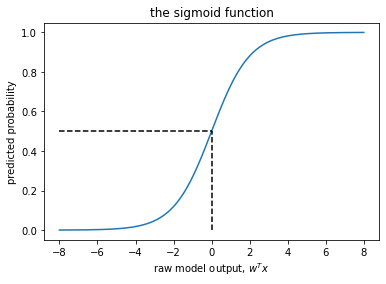

In [196]:
sigmoid = lambda x: 1/(1+np.exp(-x))
raw_model_output = np.linspace(-8,8,1000)
plt.plot(raw_model_output, sigmoid(raw_model_output));
plt.plot([0,0],[0,0.5], '--k')
plt.plot([-8,0],[0.5,0.5], '--k')
plt.xlabel("raw model output, $w^Tx$"); plt.ylabel("predicted probability");plt.title("the sigmoid function");

#### 3). Decision boundary

- The decision boundary is a hyperplane dividing the feature space in half. 
- The decision boundary is a $d-1$-dimensional hyperplane, where $d$ is the number of features.
- You can think of the coefficients as controlling the orientation of the boundary.

In [199]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_bin)
print("Model weights: %s"%(lr.coef_)) # these are weights
print("Model intercept: %s"%(lr.intercept_)) # this is the bias term
data = {'features': X_train.columns, 'coefficients':lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[0.04740261 0.10963683]]
Model intercept: [0.]


,features,coefficients
0,longitude,0.047403
1,latitude,0.109637


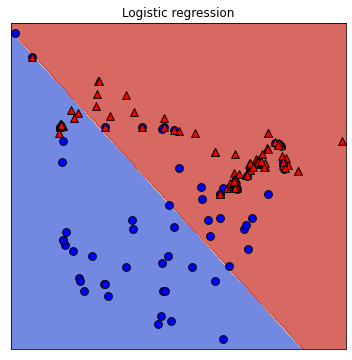

In [200]:
plt.figure(figsize=(6, 6))
plot_classifier(X_train, y_train_bin, lr, ax=plt.gca())
plt.title("Logistic regression");

#### 4). Prediction with learned weights

In [201]:
example = X_test.iloc[0,:]
example.tolist()

[-64.8001, 46.098]

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

In [202]:
np.dot(example.tolist(), lr.coef_.flatten())

1.9823446485671226

In [203]:
lr.classes_

array([0, 1])

- Our threshold here is 0
- The sign is positive and so predict class 1 (Canada in our case). 

In [205]:
lr.predict([example])

array([1])

- Predicting probabilities

In [208]:
lr.predict_proba([example])

array([[0.12106912, 0.87893088]])

- sigmoid

In [209]:
sigmoid(np.dot(example.tolist(), lr.coef_.flatten()))

0.8789308811659498

## 2. Fit

#### 1). `LogisticRegression`

> Refresher:
> - a linear classification model


1. [doc]()

```
class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
```

2. Loss function
    - Logistic loss
    - $f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$
<center>
<img src='img/lg_loss.png' width="300"/>
</center>


3. Regularization
    - `penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’`
    
4. Penalty strength
    - `C` 
    > (`alpha = 1 / (2C)`)
    - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

#### 2). Loss functions

- Learn parameters $w$ and $b$ which make predictions for each training example as close as possible to the true $y$. 
- We need two things: 
    - **Loss function**: A metric to measure how much a prediction differs from the true $y$. 
    - **Optimization algorithm**: for iteratively updating the weights so as to minimize the loss function. (More on this in 572.)   
- Assumption: We are going to assume that your classes are -1 and +1. 

##### a. least squares loss

### Why not least squares loss for logistic regression?

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- For logistic regression $y_i$ values are just +1 or -1. 
- The raw model output $w^Tx_i$ can be any number. 
- Does it make sense to use this loss function for logistic regression?
    - Not really. 
    
- Example: 
    - Suppose $w^Tx_i$ (prediction) is 101 and $y_i$ is $+1$. 
    - The model is behaving correctly, because $101$ is positive and so it will predict $+1$.
    - But according to this loss function, you have a bad prediction because the loss is huge: $(101 - 1)^2 = 10000$. 
- The squared error doesn't make sense here.    
    - It does not make sense to compare raw model outputs which can be any number to 1 or -1. 

##### b. logistic loss

  
$$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$

<center>
<img src='img/lg_loss.png' width="300"/>
</center>



#### Hinge loss (optional)

- Another loss for linear classifiers is **Hinge loss**, which is: 

$$max\{0,1-y_iw^Tx_i\}$$ 

- When you use Hinge loss with L2 regularization, it's called a linear support vector machine.  
    $$f(w) = \sum_{i=1}^n max\{0,1-y_iw^Tx_i\} + \frac{\lambda}{2} \lVert w\rVert_2^2$$
- For more mathematical details on these topics see the following slide decks from CPSC 340. 
    - [Linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L20.pdf)
    - [More on linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L19.pdf)
- It will make more sense when you learn about optimization.     

#### 3). Clarification


### a. Sigmoid vs. logistic loss

> - A common source of confusion
> - They look very similar and both are used in logistic regression.
> - They have very different purposes. 


- Sigmoid: 
$$\frac{1}{(1+\exp(-z))}$$
    - Maps $w^Tx_i$ to a number in $[0,1]$, to be interpreted as a probability. 
    - <b><font color=salmon size=4>This is important in `predict_proba`.</font></b>
- logistic loss: 
$$\log(1+\exp(-z))$$
    - Maps $y_iw^Tx_i$ to a positive number, which is the loss contribution from one training example. 
    - <b><font color=salmon size=4>This is important in `fit`.</font></b>



#### b. cross-entropy loss VS logistic loss

- You might see this alternative formulation for logistic loss. 
- For example see [here](https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training) or [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).


$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$

- Although this looks very different than the loss function we saw before, they produce the same loss. 
- This is also referred to as ***cross-entropy loss***. 
- Logistic loss = cross-entropy loss 


- This formulation assumes the classes to be 0 and 1. 
$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$
   
- Our previous formulation assumes classes to be -1 and +1. 
  $$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$
  
  
  
  
#### c. Error vs. loss

- With earlier methods like random forests, we just talked about accuracy (or error rate, which is 1 minus accuracy).
- With logistic regression, there are two separate metrics we need to keep in mind.
- scikit-learn's `score` returns the accuracy. 
- `error` = 1 - `accuracy`
    - measures the deviation of an observable value from a prediction
    - So, why not use the error rate as the loss, and directly maximize accuracy?
    - Because it's not a smooth function, which makes it hard to optimize.
    - This is a bit beyond the scope of the course.
- `loss` = 
    - Value of the objective function you are minimizing.

## 3. Softmax

> Standard way to convert numbers in a vector into a probability distribution.  

Intuition: 
- Exponentiate to put things in positive land. 
- Normalize to give probability distribution. 

#### 1). softmax function

In [210]:
d = 10
vec = np.random.uniform(-4, 2, d)
vec

array([ 1.70500956, -2.41782627, -3.06263088,  0.6379328 , -0.16180072,
       -2.47337752, -1.40823291, -2.93017565, -0.36095197,  1.15687044])

> softmax function

In [215]:
my_softmax = lambda z: np.exp(z)/np.sum(np.exp(z))

In [216]:
my_softmax(vec)

array([0.43524954, 0.0070504 , 0.0036998 , 0.14973136, 0.06729657,
       0.00666942, 0.0193497 , 0.0042238 , 0.05514455, 0.25158487])

> step by step

In [211]:
vec_exp = np.exp(vec)
vec_exp

array([5.50143824, 0.08911512, 0.0467645 , 1.89256453, 0.85061069,
       0.08429965, 0.24457509, 0.05338766, 0.69701248, 3.17996579])

In [213]:
vec_softmax = vec_exp/np.sum(vec_exp)
vec_softmax

array([0.43524954, 0.0070504 , 0.0036998 , 0.14973136, 0.06729657,
       0.00666942, 0.0193497 , 0.0042238 , 0.05514455, 0.25158487])

In [214]:
np.sum(vec_softmax)

0.9999999999999998

#### 2). `LogisticRegression` with `multi_class="multinomial"`

```
In the multiclass case, 
- the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’
- and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)


```

- In 571, we carried out multi-class classification with logistic regression using meta strategies such as one-vs-rest and one-vs-one. 
- You can also do multi-class classification using a different loss function called **softmax loss**, aka the categorical cross-entropy loss for logistic regression with multi-class. 



- Intuition    
    - The loss tries to make the probability of the correct class large.
    - Which forces the rest to be small since they must add to 1.
    - It's a generalization of the logistic loss to multi-class.
- Note that softmax function and softmax loss although same in spirit are different things and have different purposes. 

- Let's carry out multi-class classification with logistic regression with softmax loss or categorical cross-entropy loss. 
- Let's try it on the digits data set, which contains images of hand-written digits: 10 classes where each class refers to a digit.

## 4. Questions

### True/False questions for class discussion (Videos 1 and 2)

1. When the term $y_iw^Tx_i$ in logistic loss is positive, it means we have a correct prediction. 
> True
2. Minimizing logistic loss leads to mapping $y_iw^Tx_i$ to a positive number. 
> True
3. Using least squares loss for logistic regression makes sense because logistic regression is very similar to linear regression except that it's used for classification. 
> False
4. Logistic loss formulation we looked at expects the target values to be -1 and +1. 
> True 
5. Sigmoid and logistic loss are basically the same thing with different names. 
> False


### True/False questions for class discussion (Videos 3 and 4)
1. Loss is basically the same as error (1 - accuracy) on the training set. 
> False
2. When you apply the softmax function you may end up messing up the scale of the numbers in your vector. 
> True according to me. But kind of ambiguous.
3. You can use logistic regression with softmax or multinomial cross-entropy loss for multi-class classification problems. 
> True
4. If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect the loss to go down. 
> False 
5. If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect a lower training score but potentially higher CV score if it helped with overfitting. 
> True


# DSCI 573 - Quiz 2 practice questions. 

Note that these are just sample questions for you to get an idea about what to expect in the quiz. They are neither meant to cover all the topics we have covered in the last four lectures nor meant to be indicative of the number of questions in the actual quiz.

#### Question 1 
State whether true or false for each of the following statements related to random forests. 

1. A subset of the features is selected before building each tree in a random forest; each tree is built only using this subset.
2. Individual trees in a random forest are built on different subsets of the data.

**Solution**
1. False. A random subset of features is selected at **each split**. 
2. True


#### Question 2 
Why does scaling matter for regularized least square?

**Solution**

Penalizing $w_j^2$ or $w_j$ means different things if features j are on different scales

#### Question 3
Tell us whether you would use linear regression, L0, L1, or L2 regularization in the following scenarios. (Multiple answers are possible.)

1. If you have many irrelevant features in your dataset and you are asked to carry out feature selection. 

    **Solution**

    L0 or L1 because they have sparsity and can do feature selection. 

2. You are interested in a unique solution for $w$. 

    **Solution**

    L2 because solution $w$ is unique in case of L2. 

#### Question 4 

Suppose you ran `sklearn's` `LogisticRegression` twice: 

```
model_A = LogisticRegression(C=0.001)
model_B = LogisticRegression(C=1000)
```

Given the following weights learned by the models, identify which weights would be associated with model $A$ and which ones with model $B$. Explain why in 1 to 2 sentences. 

$$
w^1 = \begin{bmatrix}0.0023 \\0.015 \\  1.033 \\ 0.002 \end{bmatrix}, \quad  w^2 = \begin{bmatrix}0.3\\100.12\\34.34\\0.1\end{bmatrix}.
$$ 

**Solution**

- $w^1$ with `model_A`
- $w^2$ with model `model_B`
- larger C -> lower regularization strength -> larger weights
- smaller C -> higher regularization strength -> smaller weights. 

#### Question 5
Why do you care about model interpretability?

**Solution**

Model interpretability can be leveraged by domain experts to diagnose systematic errors and
underlying biases of complex ML systems.